# Environmental parameter: $\Sigma_5$ (or $\delta_5$)

According to [Cooper et al. 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.383.1058C/abstract), the $\delta_5$ parameter, or overdensity calculated by finding normalized surface density to the fifth nearest neighbor (within $\pm$1,000 km/s), is a good way to parameterize environment.

We can restrict the $\alpha.40$ catalog to $z < 0.05$ ish, which allows us to get a high-fidelity sample of $\alpha.40$ neighbors to within $z < .053$ from the [NSA catalog](http://nsatlas.org/data).

In [35]:
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import match_coordinates_sky, SkyCoord
import astropy.units as u

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tqdm

%matplotlib inline

In [2]:
a40 = pd.read_csv('../data/a40.datafile1.csv', index_col='AGCNr')

nsa = fits.getdata('../../dusty-halos/data/nsa_v0_1_2.fits')

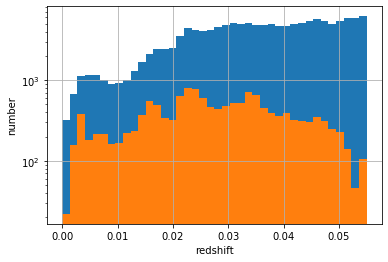

In [3]:
plt.hist(nsa['Z'], bins=40, range=[0, .055])
(a40.Dist * 70 / 3e5).hist(bins=40, range=[0, .055])
plt.yscale('log')
plt.xlabel('redshift')
plt.ylabel('number');

In [4]:
a40.sample(3)

,Name,RAdeg_HI,Decdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,errW50,HIflux,errflux,SNR,RMS,Dist,logMsun,HIcode,OCcode,NoteFlag
AGCNr,,,,,,,,,,,,,,,,,
210497,I2941,174.04460,10.05111,174.04126,10.05528,6210,261,23,2.87,0.11,17.1,2.32,93.7,9.77,1,I,*
721384,NaN,139.93457,24.55250,139.92458,24.55222,7539,203,17,1.03,0.07,8.0,2.01,111.6,9.48,1,I,NaN
198507,NaN,138.85583,25.41972,138.85750,25.41944,502,37,3,0.68,0.04,11.4,2.14,7.4,6.95,1,I,NaN


In [5]:
# get all things more than 10 Mpc away
a40_coords = a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)][['RAdeg_OC', 'DECdeg_OC']]
a40_vel = a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)]['Dist'] * 70 


In [6]:
a40_coords = SkyCoord(ra=a40_coords.RAdeg_OC, dec=a40_coords.DECdeg_OC, unit=u.deg)
nsa_coords = SkyCoord(ra=nsa['RA'], dec=nsa['DEC'], unit=u.deg)

In [36]:
c = FlatLambdaCDM(H0=70, Om0=0.3)

In [39]:
match_coordinates_sky(a40_coords[0], nsa_coords, nthneighbor=5)[1][0].rad

0.0055106382026183474

In [49]:
# physical distance to fifth nearest neighbor
D_5 = []

for ra_dec, vel in tqdm.tqdm_notebook(zip(a40_coords, a40_vel), total=len(a40_vel)):
    vel_range = (nsa['z'] - 1000 < vel / 3e5) & (nsa['z'] + 1000 > vel / 3e5)
    ang = match_coordinates_sky(ra_dec, nsa_coords[vel_range], nthneighbor=5)[1][0].rad
    D_5.append(c.angular_diameter_distance(vel / 3e5) * ang)


In [54]:
# Sigma_5 (in units of Mpc^-2)
Sigma_5 = 3 / (np.pi * np.array([D.value for D in D_5])**2)

# normalize (1 + delta_5)
# delta_5 /= np.median(delta_5)

Note that we can later make spatial or redshift cuts to avoid edge effects.

In [55]:
# a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)].index

In [55]:
overdensity = pd.DataFrame({'Sigma_5': Sigma_5.flatten(), 'AGCNr': np.array(a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)].index)})
overdensity.to_csv('../data/a.40-Sigma_5.csv')

In [56]:
overdensity = pd.read_csv('../data/a.40-Sigma_5.csv')

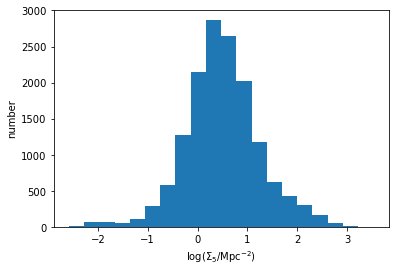

In [57]:
a40_log_d5 = np.log10(overdensity.Sigma_5)

plt.hist(a40_log_d5, bins=20)
plt.xlabel(r'log($\Sigma_5 / \rm Mpc^{-2}$)')
plt.ylabel('number');

# Same thing with xGASS

In [93]:
xgass = pd.read_csv('../data/xGASS_representative_sample.csv')

In [94]:
xgass_coords = SkyCoord(ra=xgass.RA, dec=xgass.DEC, unit=u.deg)
xgass_z = xgass.zSDSS

In [95]:
xgass_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(1.9954000e-01, 14.27755), (5.0344000e-01, 15.02561),
     (5.4247000e-01, 14.1362 ), ..., (3.5828452e+02, 16.06442),
     (3.5918533e+02, 13.90986), (3.5944820e+02, 15.61368)]>

In [96]:
D_5 = []

for ra_dec, z in tqdm.tqdm_notebook(zip(xgass_coords, xgass_z), total=len(xgass_z)):
    vel_range = (nsa['z'] - 1000/3e5 < z) & (nsa['z'] + 1000/3e5 > z)
    ang = match_coordinates_sky(ra_dec, nsa_coords[vel_range], nthneighbor=5)[1][0].rad
    D_5.append(c.angular_diameter_distance(z) * ang)

In [97]:
Sigma_5 = 3 / (np.pi * np.array([D.value for D in D_5])**2)

# delta_5 = Sigma_5 / np.median(Sigma_5)

In [98]:
overdensity = pd.DataFrame({'Sigma_5': Sigma_5.flatten(), 'GASS': xgass.GASS})
overdensity.set_index('GASS', inplace=True, drop=True)
overdensity.to_csv('../data/xGASS-Sigma_5.csv', )

In [99]:
overdensity = pd.read_csv('../data/xGASS-Sigma_5.csv', )
xgass_log_d5 = np.log10(overdensity.Sigma_5)


# Point density

In [30]:
H, xedges, yedges = np.histogram2d(nsa_coords.ra, nsa_coords.dec, bins=(300, 300))

/home/john/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


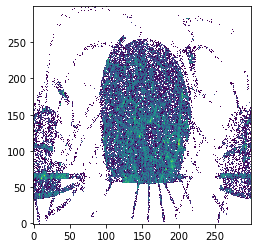

In [33]:
plt.imshow(np.log10(H.T), origin='lower')

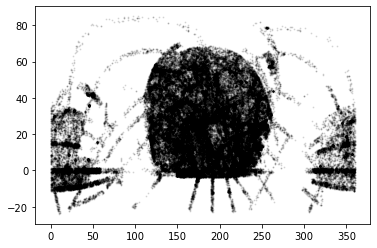

In [24]:
plt.scatter(nsa_coords.ra, nsa_coords.dec, s=1, c='k', alpha=0.1)

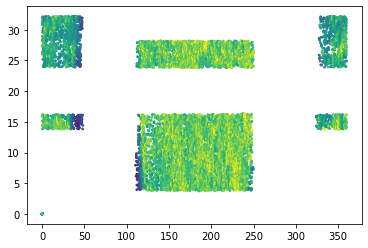

In [21]:
plt.scatter(a40_coords.ra, a40_coords.dec, s=3, c=a40_log_d5, vmin=-2, vmax=2)

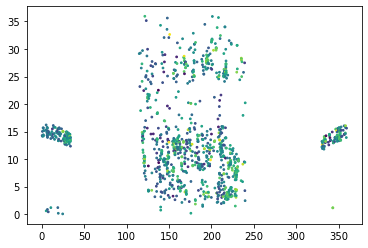

In [22]:
plt.scatter(xgass_coords.ra, xgass_coords.dec, s=3, c=xgass_log_d5, vmin=-2, vmax=2)

# Figures summarizing all findings

**Note that I'm using $\Sigma_5$ which is just the un-normalized version of $\delta_5$**. This allows me to compare xGASS and ALFALFA.

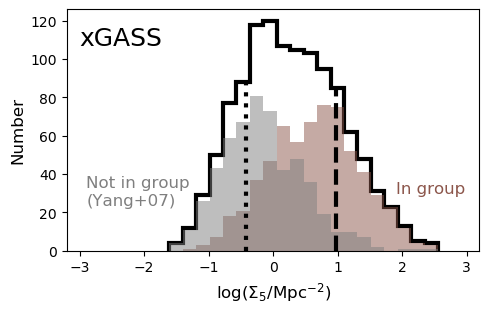

In [104]:
overdensity = pd.read_csv('../data/xGASS-Sigma_5.csv', )

plt.figure(figsize=(5, 3), dpi=100)


_, xgass_bins, _ = plt.hist(np.log10(overdensity.Sigma_5), bins=20, label='xGASS', histtype='step', lw=3, color='k')


plt.vlines(np.quantile(np.log10(overdensity.Sigma_5), 0.2), 1e-5, 88, ls=':', lw=3, color='k0')
plt.vlines(np.quantile(np.log10(overdensity.Sigma_5), 0.8), 1e-5, 85, ls='--', lw=3, color='k')


plt.hist(np.log10(overdensity.Sigma_5)[xgass.env_code_B != 1], bins=xgass_bins, color='C5', lw=2, alpha=0.5)
plt.hist(np.log10(overdensity.Sigma_5)[xgass.env_code_B == 1], bins=xgass_bins, color='C7', lw=2, alpha=0.5)

plt.xlabel(r'log($\Sigma_5/{\rm Mpc}^{-2}$)', fontsize=12)
plt.ylabel('Number', fontsize=12);

plt.xlim(-3.2, 3.2)
# plt.ylim(0, 10)

plt.text(-2.9, 24, 'Not in group\n(Yang+07)', fontsize=12, color='C7')
plt.text(1.9, 30, 'In group', fontsize=12, color='C5')

# plt.title('xGASS')
# plt.legend(fontsize=10);

plt.text(0.03, 0.85, r'xGASS', transform=plt.gca().transAxes, fontsize=18)

plt.subplots_adjust(left=0.15, bottom=0.17, right=0.975, top=0.975)

plt.savefig(f'../results/figures/xGASS_Sigma5.png')

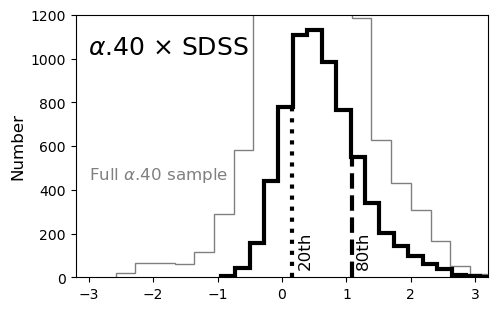

In [81]:
# a40 = (pd.read_csv('../data/a.40-delta_5.csv')
#        .join(pd.read_csv('../data/a40-SDSS_gas-frac.csv', index_col='AGCNr'), on='AGCNr')
#        .join(pd.read_csv('../data/a40.datafile3.csv', index_col='AGCNr'), on='AGCNr')
#       )
# a40 = a40[(a40.z_sdss < 0.05) & (a40.logfgas.notna())]

a40 = (pd.read_csv("../data/a40-SDSS_gas-frac.csv")
        .join(pd.read_csv("../data/a.40-Sigma_5.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_a40')
        .join(pd.read_csv("../data/a40.datafile3.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_sdss')
)

plt.figure(figsize=(5, 3), dpi=100)

# parent sample
plt.hist(np.log10(pd.read_csv("../data/a.40-Sigma_5.csv").Sigma_5), histtype='step', bins=20, color='k', alpha=0.5)

a40 = a40[(a40.z_sdss < 0.05) & (a40.logfgas.notna()) & np.log10(a40.Sigma_5).notna()].copy()

# main plot
plt.hist(np.log10(a40.Sigma_5), bins=20, histtype='step', lw=3, color='k')

plt.vlines(np.quantile(np.log10(a40.Sigma_5), 0.2), 0, 770, ls=':', lw=3, color='k')
plt.vlines(np.quantile(np.log10(a40.Sigma_5), 0.8), 0, 560, ls='--', lw=3, color='k')

plt.text(0.25, 50, '20th', fontsize=12, rotation=90)
plt.text(1.15, 50, '80th', fontsize=12, rotation=90)

plt.xlim(-3.2, 3.2)
plt.ylim(0, 1200)
# plt.xlabel(r'log($\Sigma_5/{\rm deg}^{-2}$)', fontsize=12)
plt.ylabel('Number', fontsize=12);
# plt.yscale('log')
# plt.legend(loc='upper left', fontsize=12)

plt.text(0.03, 0.85, r'$\alpha$.40 $\times$ SDSS', transform=plt.gca().transAxes, fontsize=18)

plt.text(-3., 450, r'Full $\alpha$.40' + ' sample', c='k', fontsize=12, alpha=0.5)

plt.subplots_adjust(left=0.15, bottom=0.1, right=0.975, top=0.975)

plt.savefig(f'../results/figures/a40_Sigma5.png')